In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib import rc
from matplotlib.colors import LinearSegmentedColormap as colormap
from IPython.display import HTML
import math
import os, sys
sys.path.append(os.path.relpath("./src"))
from kitaev_chain import kitaev_chain_model, quench_simulation
FFwriter=FFMpegWriter(fps=30, extra_args=['-vcodec', 'libx264'])
from utils import intersections, to_n, s0, sx, sy, sz, maj_ordered, tensor_product, canon_eigen, expm, U, c, zero, LOSCHMIDT_BDG, LOSCHMIDT_TFIM, STATES

## Implementing the ghost sites method from this [article](https://arxiv.org/abs/2003.00095) 

In [2]:
def fermion_chain_from_spin_chain_params(n_sites, J, h_z, h_edges_x):
    n = n_sites + 2
    mu = np.ones(n) * h_z; mu[0] = mu[-1] = 0
    t = np.ones(n - 1) * J; t[0] = t[-1] = h_edges_x
    t *= .5
    delta = -t
    return kitaev_chain_model(n, mu, t, delta, True)

C:\Users\t-hareldamti\AppData\Local\Temp\ipykernel_29960\526089185.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  energies[:, i] = sorted(evals)
C:\Users\t-hareldamti\AppData\Local\Temp\ipykernel_29960\526089185.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


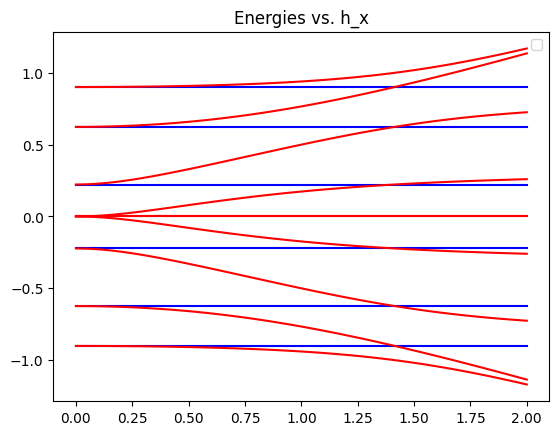

In [11]:
n = 5
res = 50
J_range = np.linspace(0, 2, res)
energies = np.zeros((2 * n, res))
energies_2 = np.zeros((2 * (n - 2), res))
for i, J in enumerate(J_range):
    H_ = fermion_chain_from_spin_chain_params(n - 2, 1, 1, J)
    H_2 = kitaev_chain_model(n - 2, 1, .5, -.5)
    evals, _ = np.linalg.eig(H_.bdg_hamiltonian())
    evals2, _ = np.linalg.eig(H_2.bdg_hamiltonian())
    energies[:, i] = sorted(evals)
    energies_2[:, i] = sorted(evals2)

plt.plot(J_range, energies_2.T, 'b')
plt.plot(J_range, energies.T, 'r')
plt.title("Energies vs. h_x")
plt.legend()
pass

In [4]:
n_sites = 4
n = n_sites + 2
k = 1e-1
H0 = fermion_chain_from_spin_chain_params(n_sites, 1, 1, 5)
H = fermion_chain_from_spin_chain_params(n_sites, 1, 1, 0)
sim = quench_simulation(H0, H)

U, V numerical incompabillity


### Test if $\eta_0 = \frac{1}{2} (c_0 + c_{0}^{\dagger}+c_{L+1} - c_{L+1}^{\dagger})$ is an eigenvector of H

In [5]:
eta0 = np.zeros(2 * n)
eta0[0] = eta0[n - 1] = eta0[n] = 0.5
eta0[2 * n - 1] = -0.5

In [6]:
H0.bdg_hamiltonian() @ eta0

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [7]:
H0.bdg_eigen(forceEvecs=eta0.reshape(1, 2 * n))
vac = intersections([sp.linalg.null_space(H0.psi(i), rcond=1e-1) for i in range(0, H0.n)])
H0.vac = vac

U, V numerical incompabillity


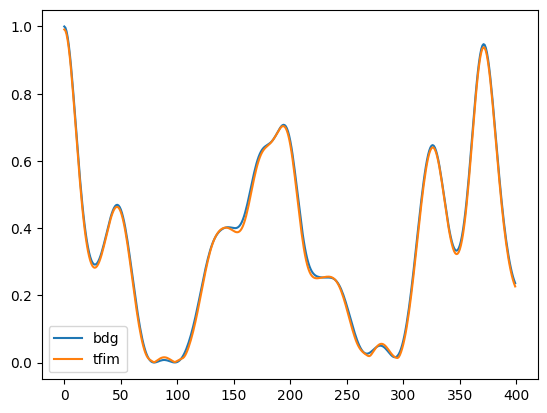

In [8]:
sim.fill_sim(.2, 80)
plt.plot(sim.simulation_data[LOSCHMIDT_BDG], label="bdg")
plt.plot(sim.simulation_data[LOSCHMIDT_TFIM] ** (2.0 / (n - 2)), label="tfim")
plt.legend()

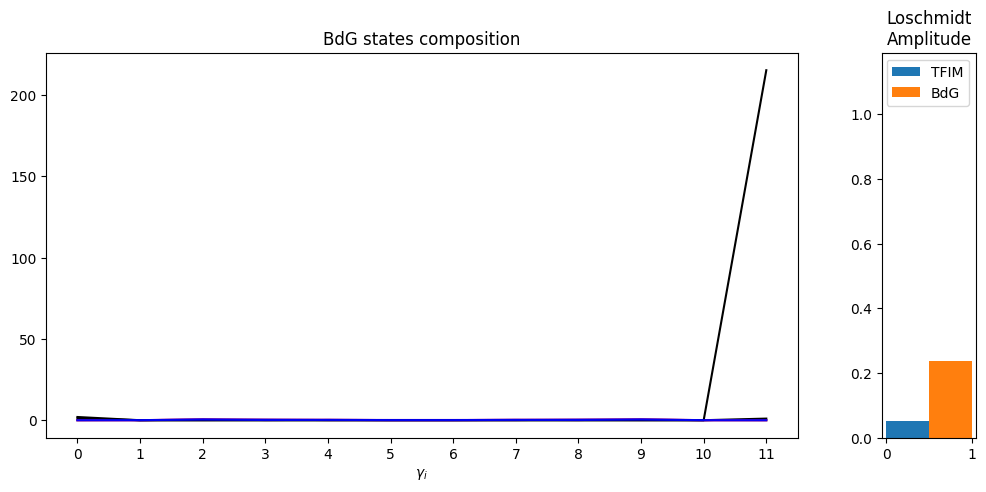

In [9]:
if True:
    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [8, 1]})
    fig.set_size_inches((12, 5))
    plots = [None for _ in range(2 * n)]

    ax1.set_title("BdG states composition")
    ax1.set_xlabel("$\\gamma_{i}$")
    ax1.set_xlim(-.5, 2 * n - .5)
    ax1.set_xticks(range(2 * n))

    ax2.set_title("Loschmidt\nAmplitude")
    ax2.set_ylim(0,1.19)


    for i, (energy, state) in enumerate(filter(lambda pair: True, zip(sim.H0.bdg_evals_sorted, sim.simulation_data[STATES][0].T))):
        plots[i] = ax1.plot(range(2 * n), np.absolute(maj_ordered(state)) ** 2, color=(1 if energy > 1e-4 else 0, 0, 1 if energy < -1e-4 else 0, math.exp(-(energy * 1.5) ** 2)), label={f"{i} - {energy:.3f}"})[0]
    l_tfim = ax2.bar(0.25, sim.simulation_data[LOSCHMIDT_TFIM][0], 0.5, label='TFIM')
    l_bdg = ax2.bar(0.75, sim.simulation_data[LOSCHMIDT_BDG][0], 0.5, label='BdG')
    ax2.legend()

    def init(): return *plots, *l_tfim.patches, *l_bdg.patches

    def animate(frame):
        for i in range(2 * n):
            plots[i].set_data(range(2 * n), np.absolute(maj_ordered(sim.simulation_data[STATES][frame][:, i]) ** 2))
        l_tfim.patches[0].set_height(sim.simulation_data[LOSCHMIDT_TFIM][frame])
        l_bdg.patches[0].set_height(sim.simulation_data[LOSCHMIDT_BDG][frame])
        return *plots, *l_tfim.patches, *l_bdg.patches

    anim = FuncAnimation(fig, animate,
                    frames = len(sim.simulation_data[LOSCHMIDT_TFIM]), interval = 30, blit = True)

    anim.save(f"simulations/quench1.mp4", writer=FFwriter)